In [8]:
def coupon_csvdata_read(testdata_file_name: str,
                         force_index: int,
                         strain_index: int):
    """
    Read tensile coupon test data from a CSV file and extract force and strain columns.

    Args:
        testdata_file_name (str): Path to the CSV file containing the test data.
        force_index (int): 1-based column index for the force data.
        strain_index (int): 1-based column index for the strain data.

    Returns:
        tuple:
            df_new (pd.DataFrame): DataFrame containing only 'Force' and 'Strain' columns.
            sample_name (str): Name of the sample extracted from the file name (without extension).

    Notes:
        - The CSV file is expected to have a header in the first row.
        - The second row is skipped during reading (`skiprows=[1]`).
        - The first column is treated as the index column (`index_col=0`).
        - Force and strain columns are extracted based on the provided 1-based indices.
    """
    
    import pandas as pd
    df = pd.read_csv(testdata_file_name, skiprows=[1], index_col=0)
    Force = df[df.columns[force_index - 1]]
    Strain = df[df.columns[strain_index - 1]]
    df_new = pd.concat([Force, Strain], axis=1)
    df_new.columns = ['Force', 'Strain']
    sample_name = testdata_file_name[:-4]
    return sample_name, df_new, 

In [9]:
data = coupon_csvdata_read('S5_bench.csv',1,2)

In [10]:
data[0]

'S5_bench'

C:\Users\chunhao\AppData\Local\Temp\ipykernel_45856\3834817911.py:58: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  strain_up = strain[:idx_peak+1]
C:\Users\chunhao\AppData\Local\Temp\ipykernel_45856\3834817911.py:59: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  stress_up = stress[:idx_peak+1]


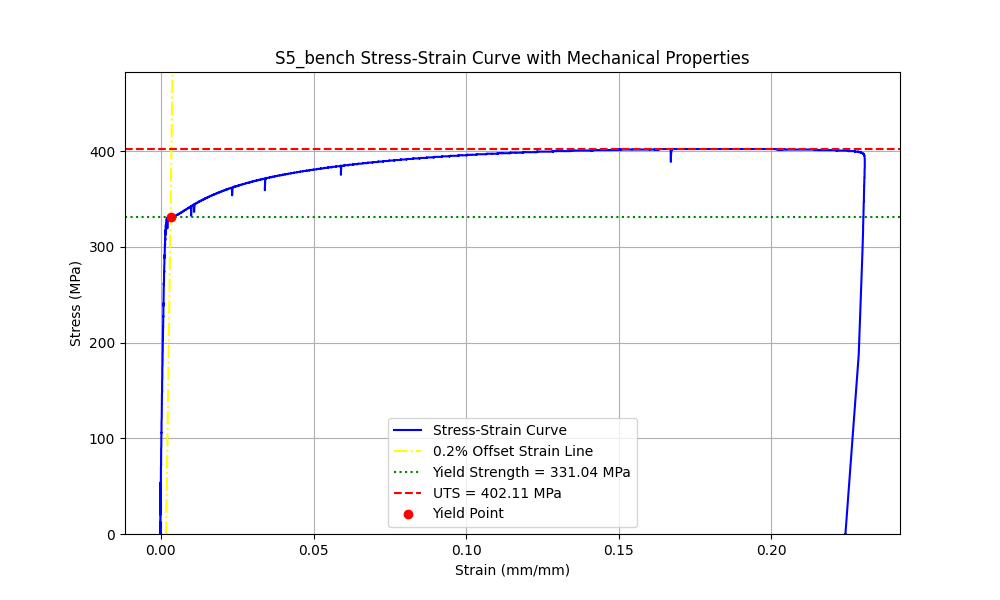

Sample: S5_bench
Young's Modulus (E): 231643.72 MPa
Ultimate Tensile Strength (UTS): 402.11 MPa
Yield Strength: 331.04 MPa
0.0032772140653146795
----------------------------------------


('S5_bench',
 {'E_MPa': np.float64(231643.7201400504),
  'UTS_MPa': np.float64(402.1077456),
  'Yield_Strength_MPa': np.float64(331.04116554095026)})

In [14]:
%matplotlib widget
coupon_test_analysis(data[0],data[1]['Force'],data[1]['Strain'])

In [15]:
def coupon_test_analysis_base (testdata_file_name: str,
                 thickness: float = 2.5, 
                 width: float = 10, 
                 showfig: bool = True,
                 savefig: bool = False,
                 lower_bound: float = 0.1, 
                 upper_bound: float = 0.3,
                 ):
    """
    Post-process a tensile coupon test and plot stress-strain curve.
     
    To active with Jupyter Lab, '%matplotlib widget' is required
    
    Args:
        Thickness (float): Specimen thickness in mm.
        Width (float): Specimen width in mm.
        file_name (str): CSV file containing test data.
        low_bound (float): Lower bound of elastic region as fraction of UTS.
        upper_bound (float): Upper bound of elastic region as fraction of UTS.

    Returns:
        fig (matplotlib.figure.Figure): Figure object containing the plot.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    #%matplotlib widget
    # Constants
    thickness # mm
    width # mm
    area = thickness * width  # Calculate the area of the specimen
    
    # Load tensile test data
    df = pd.read_csv(testdata_file_name, header=[0])
    
    #df.columns = [f"{col[0]} {col[1]}" for col in df.columns]
    
    # Extract relevant columns
    #time = df["Time (sec)"]
    #displacement = df["Crosshead separation (mm)"]
    force = df[df.columns[1]]
    elongation = df[df.columns[2]]
    strain = elongation # Strain in mm/mm
    
    # Calculate stress and strain
    force = force * 1000 # Convert kN to N
    stress = (force / area)  # N/m^2 or Pa
    uts = stress.max()
    
    #find the data before uts
    idx_peak = np.argmax(stress)
    strain_up = strain[:idx_peak+1]
    stress_up = stress[:idx_peak+1]
    
    #Boundary for 20% - 50% of UTS
    lower_bound = 0.1 * uts
    upper_bound = 0.3 * uts
    
    elastic_reg = (lower_bound <= stress_up) & (stress_up <= upper_bound)
    
    stress_ela = stress_up[elastic_reg]
    strain_ela = strain_up[elastic_reg] 
    
    E, intercept = np.polyfit(strain_ela, stress_ela, 1)
    #print(f"Young's Modulus is: {E} MPa",)
    E_GPa = E / 1000  # Convert MPa to GPa
    #print(f"Intercept: {intercept} MPa")
   
    # Select over 30% of UTS, as yield stress will over 30% uts
    strain_new = elongation
    stress_new = force / area
    mask = (lower_bound <= stress)
    strain_mask = strain_new[mask]
    stress_mask = stress_new[mask]
    
    offset_decimal = 0.002  # 0.2% in decimal
    offset_line = E * (strain_new - offset_decimal) + intercept

    #Find the Yield strength
    diff = stress_mask - offset_line
    cross_index = np.where(diff <= 0)[0][0] 
    x1 = strain_mask[cross_index-1]
    x2 = strain_mask[cross_index]
    y1 = diff[cross_index-1]
    y2 = diff[cross_index]
    yield_strain = x1 - y1 * (x2 - x1) / (y2 - y1)
    yield_strength = np.interp(yield_strain, strain_new, stress_new)

    #Plot
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot(strain, stress, label='Stress-Strain Curve', color='blue')
    ax.plot(strain_new, offset_line, label='0.2% Offset Strain Line', color='yellow',linestyle = '-.')
    
    ax.axhline(y=yield_strength, label=f'Yield Strength = {yield_strength:.2f} MPa', color='green', linestyle = 'dotted')
    ax.axhline(y=uts, color='red', linestyle = '--', label=f'UTS = {uts:.2f} MPa')
    ax.plot(yield_strain, yield_strength, 'ro', label='Yield Point')
    
    ax.set_xlabel('Strain (mm/mm)')
    ax.set_ylabel('Stress (MPa)')
    ax.set_title(testdata_file_name[:-4]+' Stress-Strain Curve with Mechanical Properties')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0, 1.2 *uts)

    #Show fig or not
    if showfig == True:
        plt.show()
    else:
        plt.close(fig)

    # Save fig or not
    if savefig == True:
        fig.savefig(testdata_file_name[:-4], dpi=300, bbox_inches='tight')
    
    # Print results
    print(f"Sample: {testdata_file_name[:-4]}")
    print(f"Young's Modulus (E): {E:.2f} MPa")
    print(f"Ultimate Tensile Strength (UTS): {uts:.2f} MPa")
    print(f"Yield Strength: {yield_strength:.2f} MPa")
    print(yield_strain)
    print('-' * 40)
    
    # Prepare results dictionary
    results = {
        "E_MPa": E,
        "UTS_MPa": uts,
        "Yield_Strength_MPa": yield_strength
    }
    return testdata_file_name[:-4], results, yield_strain

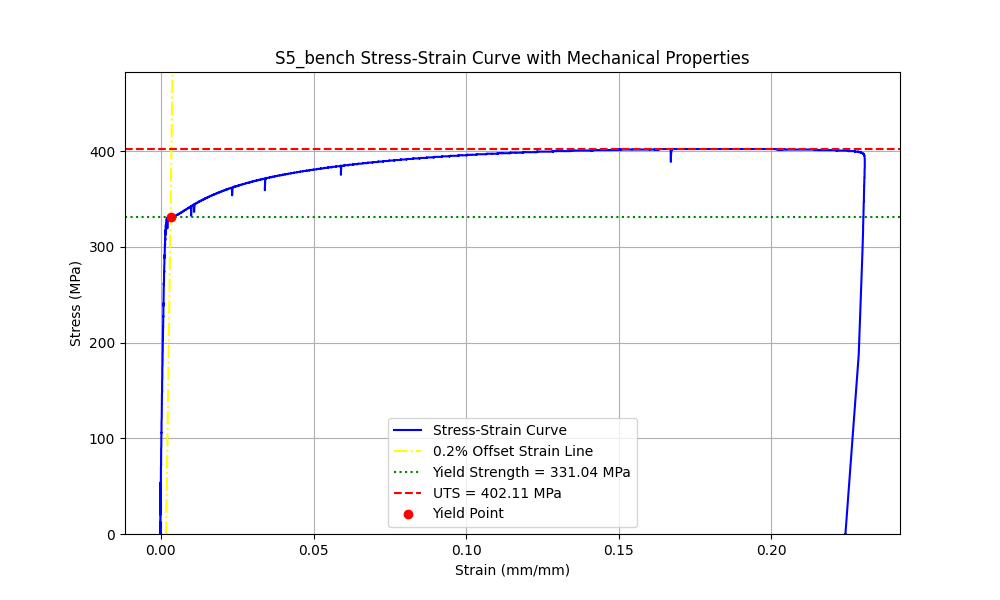

Sample: S5_bench
Young's Modulus (E): 231643.72 MPa
Ultimate Tensile Strength (UTS): 402.11 MPa
Yield Strength: 331.04 MPa
0.0031348473971851377
----------------------------------------


('S5_bench',
 {'E_MPa': np.float64(231643.7201400504),
  'UTS_MPa': np.float64(402.1077456),
  'Yield_Strength_MPa': np.float64(331.0444281556643)},
 np.float64(0.0031348473971851377))

In [17]:
coupon_test_analysis_base('S5_bench.csv')

In [46]:
def coupon_sample_geodata_read (Excelfile_name: str):
    '''
    Reads sample geometric properties from an Excel file.

    Parameters
    ----------
    Excelfile_name : str
        The name of the Excel file to read, located in the current working directory.

    Returns
    -------
    list
        A list containing:
        - sample_file_name (sample name from cell A2 with ".csv" extension)
        - thickness (value from cell C2)
        - width (value from cell B2)
    '''
    
    from openpyxl import load_workbook
    from pathlib import Path
    sample_data_file = Path.cwd()/Excelfile_name
    wb = load_workbook(sample_data_file)
    ws = wb.worksheets[0]
    samples = []
    for row in ws.iter_rows(min_row=2, values_only=True):  
        if all(cell is None for cell in row):  # skip empty
            continue
        # 取前三列数据
        sample_file_name = str (row[0] + ".csv")
        sample_name = coupon_SampleDetails(row[0], row[1], row[2], sample_file_name)
        samples.append(sample_name)
    return samples

In [30]:
geo = coupon_sample_geodata_read('Sample Data.xlsx')

In [31]:
geo

[coupon_SampleDetails(sample_name='S1', width=2.5, thickness=10, sample_file_name='S1.csv'),
 coupon_SampleDetails(sample_name='S2', width=3, thickness=10.55, sample_file_name='S2.csv'),
 coupon_SampleDetails(sample_name='S3', width=3.1, thickness=9.89, sample_file_name='S3.csv'),
 coupon_SampleDetails(sample_name='S4', width=3, thickness=9.88, sample_file_name='S4.csv'),
 coupon_SampleDetails(sample_name='S5', width=2.56, thickness=9.6, sample_file_name='S5.csv'),
 coupon_SampleDetails(sample_name='S6', width=2.39, thickness=10.2, sample_file_name='S6.csv'),
 coupon_SampleDetails(sample_name='S7', width=3.5, thickness=10.1, sample_file_name='S7.csv'),
 coupon_SampleDetails(sample_name='S8', width=2.59, thickness=10.33, sample_file_name='S8.csv'),
 coupon_SampleDetails(sample_name='S9', width=2.6, thickness=10.8, sample_file_name='S9.csv')]

In [33]:
def coupon_batch_analysis(Coupon_geodata: str,
                          force_index: float,
                          strain_index:float,
                   showfig: bool = True,
                   savefig: bool = False):
    """
    Perform batch analysis on a list of samples and return the results.

    Parameters
    ----------
    Coupon_geodata : list
        A list of SampleDetails objects, each containing:
        - sample_file_name : Name of the sample file
        - thickness        : Sample thickness
        - width            : Sample width
    savefig : bool, optional
        Whether to save the figures generated during analysis. Default is False.

    Returns
    -------
    list
        A list of SampleAnalysisResults objects, each containing:
        - modulus_of_elasticity       : Elastic modulus (E_GPa)
        - ultimate_tensile_strength   : Ultimate tensile strength (UTS_MPa)
        - yield_Strength              : Yield strength (Yield_Strength_MPa)
    """
    SARS = []
    for Coupon_detail in Coupon_geodata:
        csvdata = coupon_csvdata_read(Coupon_detail.sample_file_name,force_index,strain_index)
        result = coupon_test_analysis(Coupon_detail.sample_file_name[:-4], 
                                      csvdata[1]['Force'],
                                      csvdata[1]['Strain'],
                                      Coupon_detail.thickness, 
                                      Coupon_detail.width, 
                                      showfig, 
                                      savefig)
        SAR = coupon_SampleAnalysisResults(result[0], result[1]['E_MPa'], result[1]['UTS_MPa'], result[1]['Yield_Strength_MPa'])
        SARS.append(SAR)
    return SARS

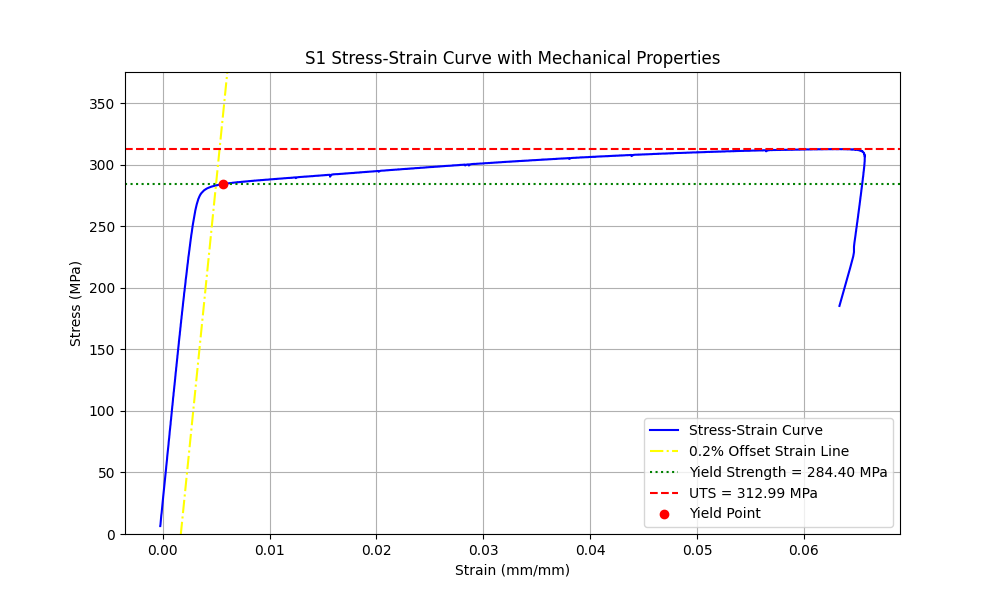

Sample: S1
Young's Modulus (E): 86376.60 MPa
Ultimate Tensile Strength (UTS): 312.99 MPa
Yield Strength: 284.40 MPa
----------------------------------------


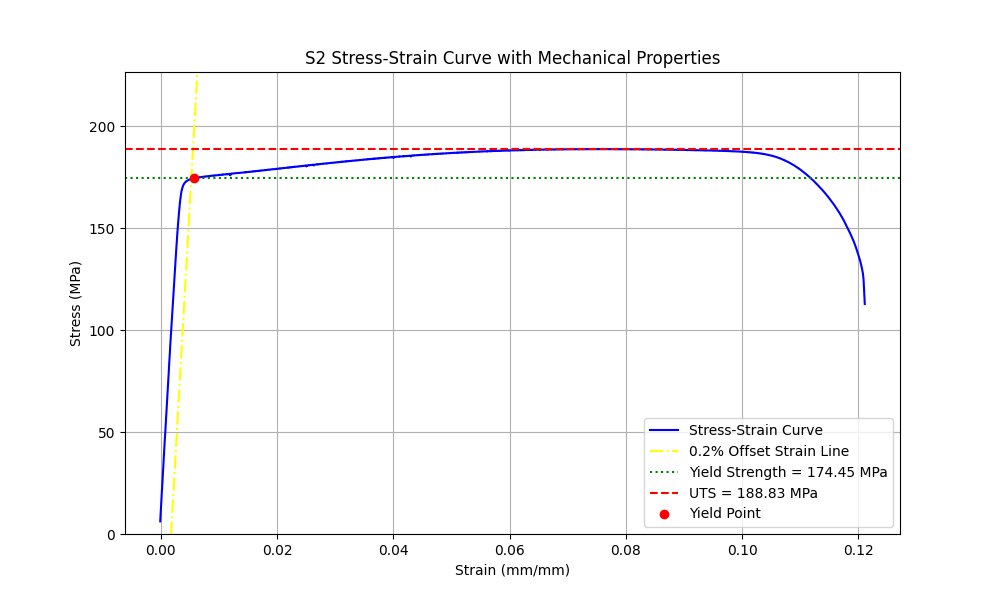

Sample: S2
Young's Modulus (E): 50035.60 MPa
Ultimate Tensile Strength (UTS): 188.83 MPa
Yield Strength: 174.45 MPa
----------------------------------------


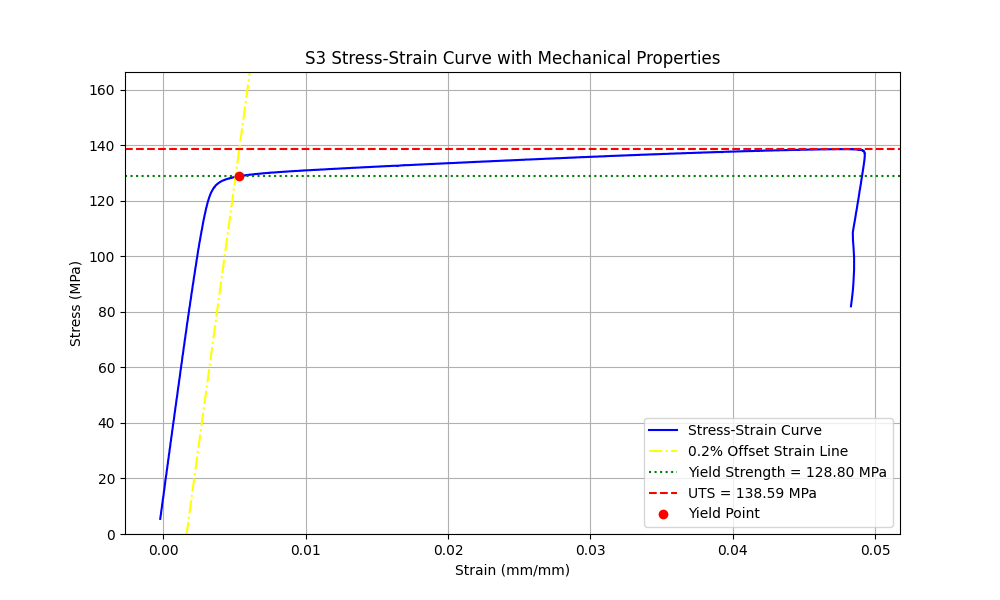

Sample: S3
Young's Modulus (E): 37483.08 MPa
Ultimate Tensile Strength (UTS): 138.59 MPa
Yield Strength: 128.80 MPa
----------------------------------------


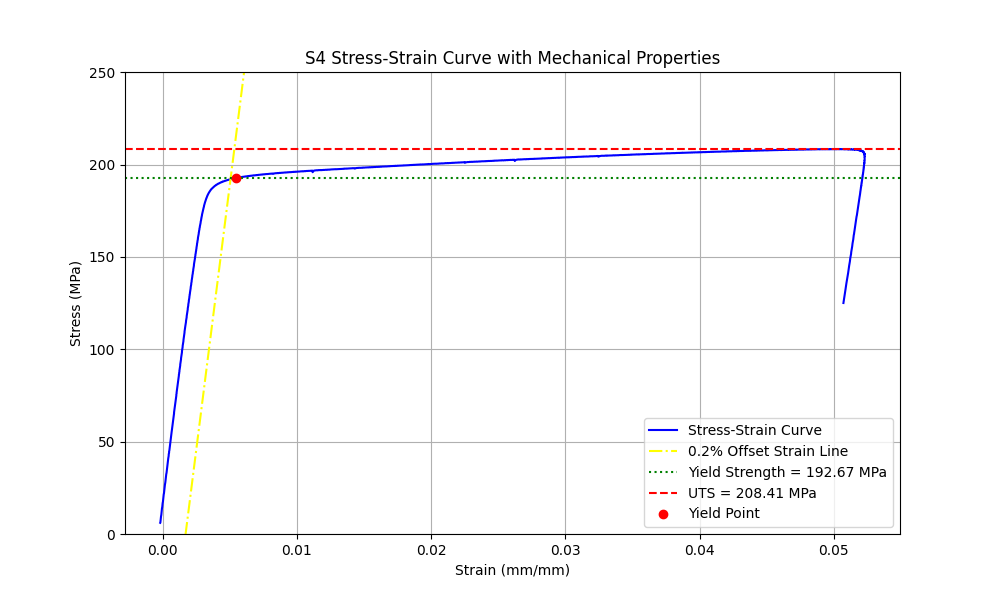

Sample: S4
Young's Modulus (E): 57384.13 MPa
Ultimate Tensile Strength (UTS): 208.41 MPa
Yield Strength: 192.67 MPa
----------------------------------------


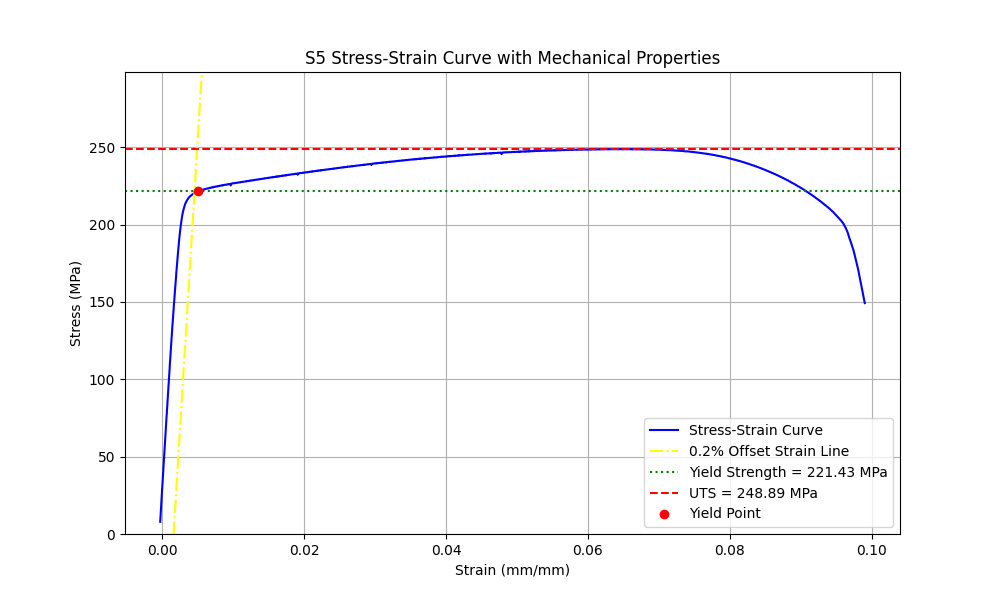

Sample: S5
Young's Modulus (E): 75029.85 MPa
Ultimate Tensile Strength (UTS): 248.89 MPa
Yield Strength: 221.43 MPa
----------------------------------------


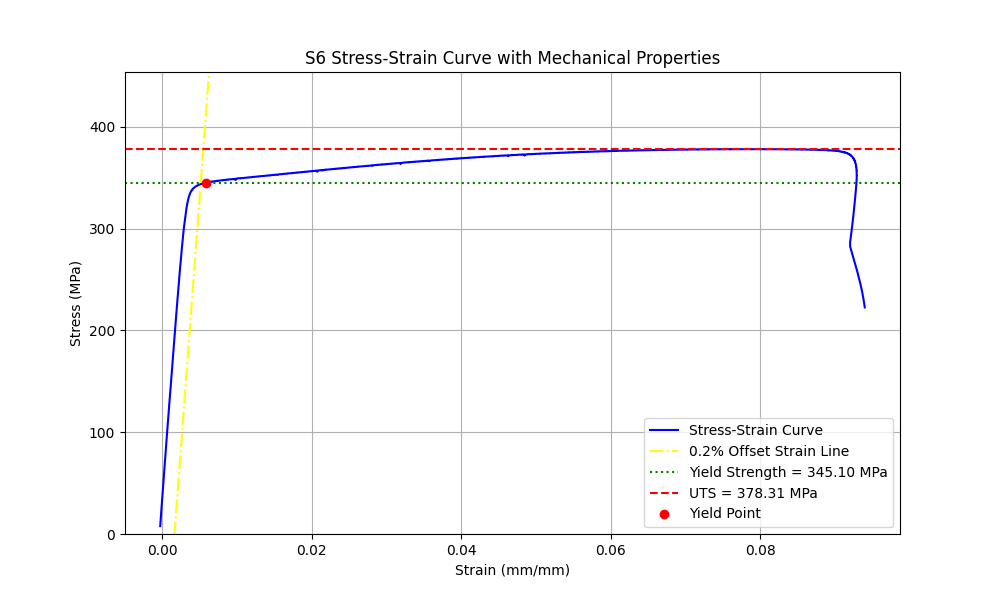

Sample: S6
Young's Modulus (E): 98205.83 MPa
Ultimate Tensile Strength (UTS): 378.31 MPa
Yield Strength: 345.10 MPa
----------------------------------------


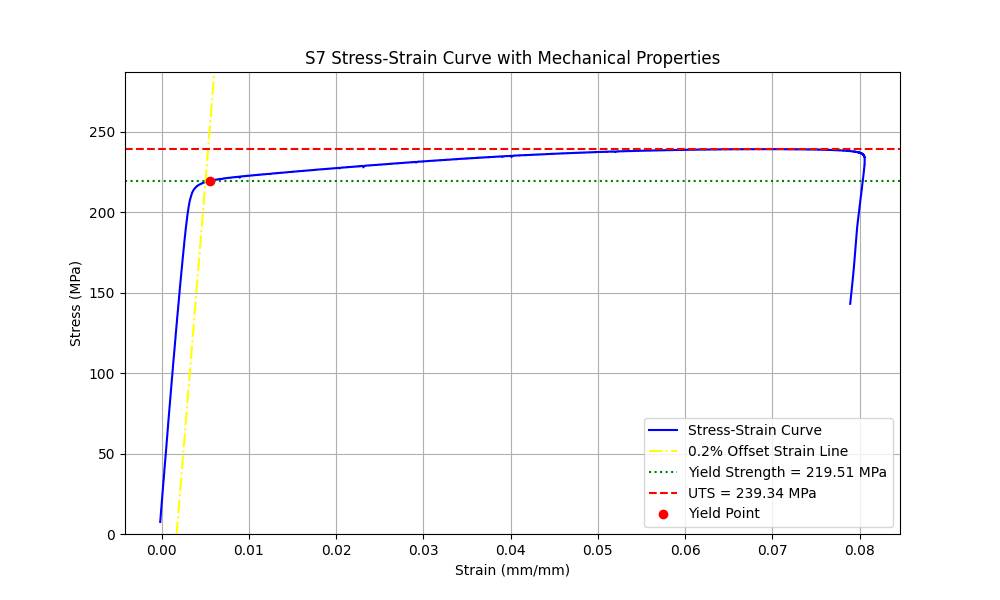

Sample: S7
Young's Modulus (E): 66453.25 MPa
Ultimate Tensile Strength (UTS): 239.34 MPa
Yield Strength: 219.51 MPa
----------------------------------------


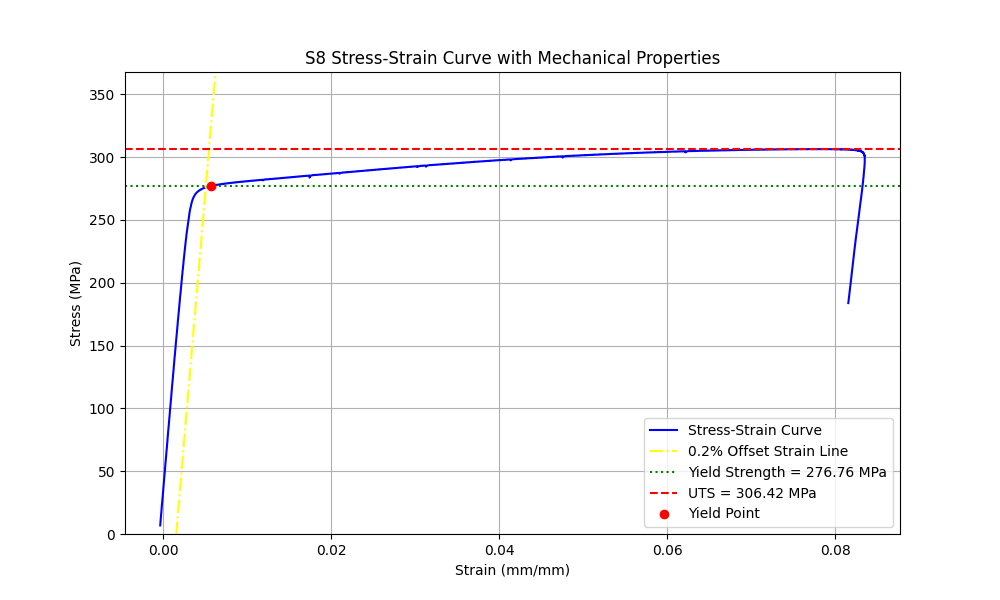

Sample: S8
Young's Modulus (E): 78497.70 MPa
Ultimate Tensile Strength (UTS): 306.42 MPa
Yield Strength: 276.76 MPa
----------------------------------------


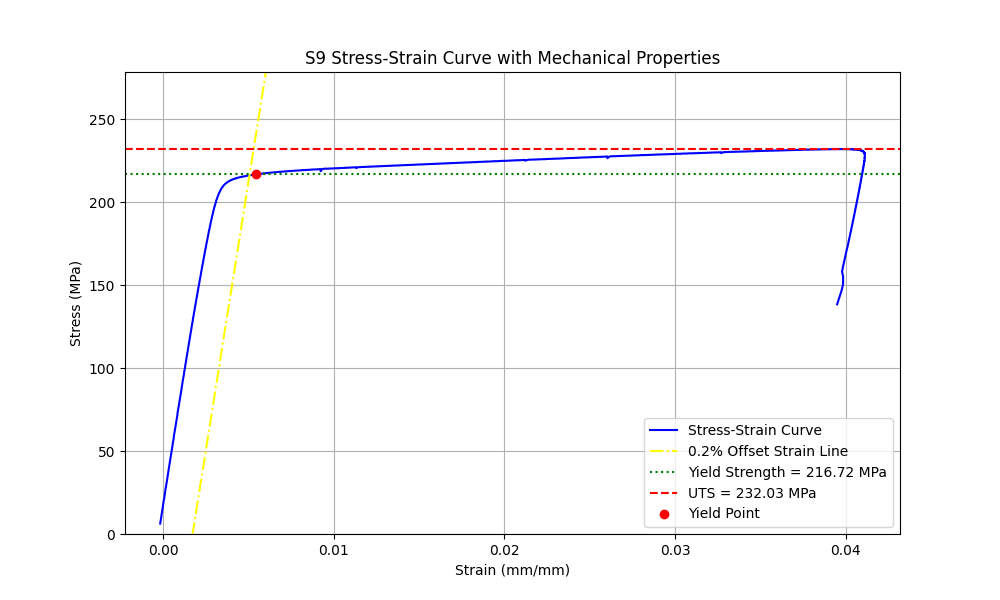

Sample: S9
Young's Modulus (E): 64799.48 MPa
Ultimate Tensile Strength (UTS): 232.03 MPa
Yield Strength: 216.72 MPa
----------------------------------------


[coupon_SampleAnalysisResults(sample_name='S1', modulus_of_elasticity=np.float64(86376.60088846678), ultimate_tensile_strength=np.float64(312.9916), yield_Strength=np.float64(284.40026114036897)),
 coupon_SampleAnalysisResults(sample_name='S2', modulus_of_elasticity=np.float64(50035.59726146941), ultimate_tensile_strength=np.float64(188.83222748815163), yield_Strength=np.float64(174.45456012041475)),
 coupon_SampleAnalysisResults(sample_name='S3', modulus_of_elasticity=np.float64(37483.07638199255), ultimate_tensile_strength=np.float64(138.5935614338367), yield_Strength=np.float64(128.79867406874303)),
 coupon_SampleAnalysisResults(sample_name='S4', modulus_of_elasticity=np.float64(57384.128372331594), ultimate_tensile_strength=np.float64(208.40553306342778), yield_Strength=np.float64(192.6685070533096)),
 coupon_SampleAnalysisResults(sample_name='S5', modulus_of_elasticity=np.float64(75029.85022927311), ultimate_tensile_strength=np.float64(248.88956705729166), yield_Strength=np.float6

In [34]:
%matplotlib widget
coupon_batch_analysis(geo,2,3)

In [ ]:
def coupon_results_save(Excelfile_name: str, analysis_results: list):
    """
    Save a list of sample analysis results into an Excel file, matching by sample name.

    Parameters
    ----------
    Excelfile_name: str
        Path to the Excel file to save the results.
    analysis_results : list
        A list of SampleAnalysisResults objects, each containing:
        - sample_name
        - modulus_of_elasticity
        - ultimate_tensile_strength
        - yield_Strength

    Notes
    -----
    - Assumes the Excel file has sample names in column A, starting from row 2.
    - Data will be written starting from column D (fourth column).
    - Overwrites the original Excel file.
    """
    from openpyxl import load_workbook

    wb = load_workbook(Excelfile_name)
    ws = wb.worksheets[0]

    # Build a dictionary for faster lookup
    result_dict = {res.sample_name: res for res in analysis_results}

    for row_idx, row in enumerate(ws.iter_rows(min_row=2, max_col=ws.max_column), start=2):
        excel_sample_name = row[0].value
        if excel_sample_name in result_dict:
            analysis_result = result_dict[excel_sample_name]
            values_to_write = [
                analysis_result.modulus_of_elasticity,
                analysis_result.ultimate_tensile_strength,
                analysis_result.yield_Strength
            ]
            for col_idx, value in enumerate(values_to_write, start=4):  # D列开始
                ws.cell(row=row_idx, column=col_idx, value=float(value))

    wb.save(Excelfile_name)
    print('The coupon test data analysis is complete.')

In [1]:
from dataclasses import dataclass
@dataclass # this thing is called a "decorator"
class coupon_SampleDetails:
    """
    Holds basic information for a sample.

    Attributes
    ----------
    sample_name : str
        Name or ID of the sample.
    width : float
        Width of the sample (geometric property, in consistent units).
    thickness : float
        Thickness of the sample (geometric property, in consistent units).
    sample_file_name : str
        Name of the associated data file for the sample, e.g., CSV file.
    """
    sample_name: str
    width: float
    thickness: float
    sample_file_name: str

@dataclass # this thing is called a "decorator"
class coupon_SampleAnalysisResults:
    """
    Stores the analysis results for a sample after mechanical testing.

    Attributes
    ----------
    sample_name : str
        Name or ID of the sample corresponding to the analysis.
    modulus_of_elasticity : float
        Elastic modulus of the sample (E, in GPa).
    ultimate_tensile_strength : float
        Maximum tensile strength of the sample (UTS, in MPa).
    yield_Strength : float
        Yield strength of the sample (in MPa).
    """
    sample_name: str
    modulus_of_elasticity: float
    ultimate_tensile_strength: float
    yield_Strength: float